From [Graph Attention Networks: Self-Attention Explained](https://towardsdatascience.com/graph-attention-networks-in-python-975736ac5c0c/?source=post_page-----24b3f60d6c95---------------------------------------)

## Introduction to the Dataset

With Graph Convolutional Networks (GCNs), every neighbor has the **same importance**. Obviously, it should not be the case. Some nodes are more essential than others.

Graph *Attention* Networks (GANs) offer a solution to this problem. To consider the importance of each neighbor, an attention mechanism assigns a **weighting factor to every connection**.

There are three classic graph datasets we can use for this work (MIT license). They represent networks of research papers, where each connection is a citation.

* **Cora**: 2708 machine learning papers belonging to one of 7 categories. Node features represent the presence (1) or absence  (0) of 1433 words in a paper (binary bag of words).

* **CiteSeer**: Bigger but similar dataset of 3312 scientific papers to classify into one of 6 categories. Node features represent the presence (1) or absene (0) of 3703 words in a paper.

* **PubMed**: 19717 scientific publications about diabetes form PubMed's database, classified into 3 categories. Node features are TF-TDF weighted word vectors from a dictionary of 500 unique words.

These datasets have been widely used by the scientific community. As a challenge, we can compare our accuracy scores to those obtained in the literature using MLPs, GCNs, and GATs.

We will focus on **CiteSeer** as a medium-sized dataset. We can directly import any of these datasets in PyTorch Geometric with the Planetoid class:

In [1]:
from torch_geometric.datasets import Planetoid

# Import dataset from PyTorch Geometric
dataset = Planetoid(root=".", name="CiteSeer")
data = dataset[0]

# Print information about the dataset
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')

/home/emoeller/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Processing...


Number of graphs: 1
Number of nodes: 3327
Number of features: 3703
Number of classes: 6
Has isolated nodes: True


Done!


Some nodes are isolated in the dataset. Correctly classifying these isolated nodes will be a challenge since we cannot rely on aggregation.

Let's plot the number of connections of each node with `degree`:

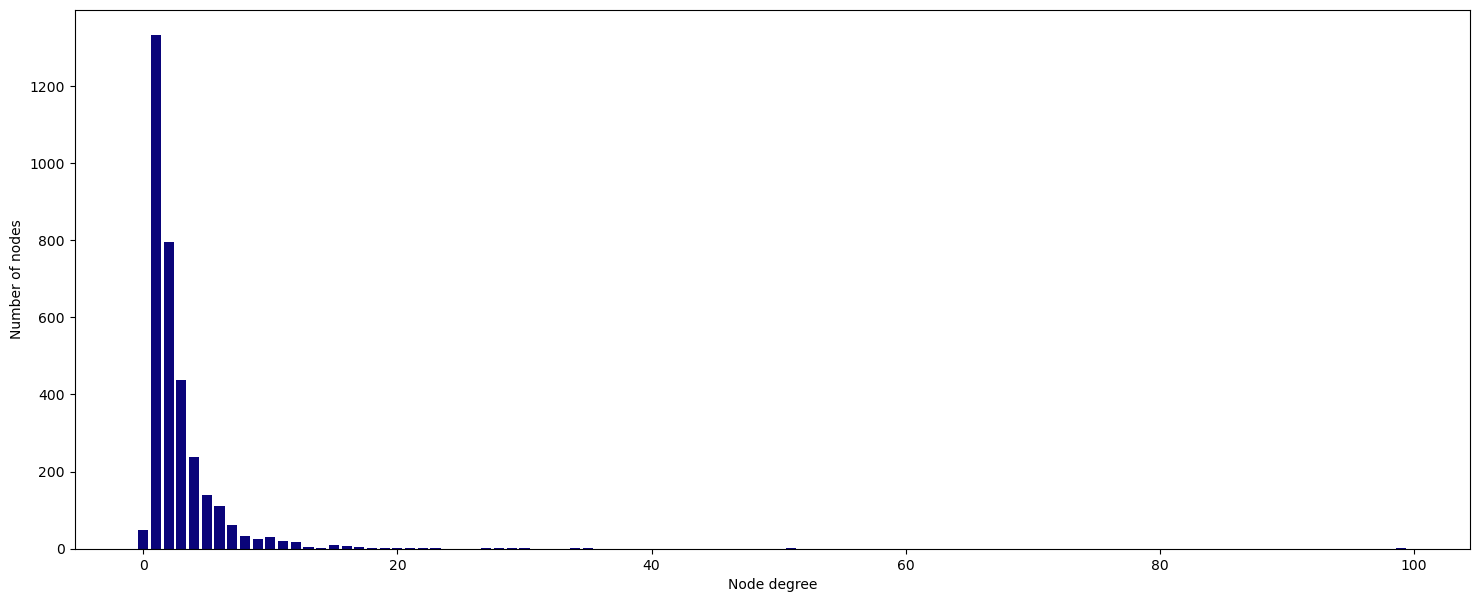

In [2]:
import matplotlib.pyplot as plt
from torch_geometric.utils import degree
from collections import Counter

# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the numebr of nodes for each degree
numbers = Counter(degrees)

# Bar Plot
fig, ax = plt.subplots(figsize=(18,7))
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(),
        numbers.values(),
        color="#0A047A")
plt.show()

## Self-Attention

Self-attention in GNNs relies on a simple idea: **nodes should not all have the same importance**.

We talk about *self*-attention (and not just attention) because inputs are compared to each other. This mechanism assigns a **weighting factor** (attention score) to each connection. Let's call $\alpha^{ij}$ the attention score between nodes $i$ and $j$.

For a node with three connections (node 1, connected to nodes 2, 3, and 4), here's how to calculate the embedding of node 1, where $W$ is a shared weight matrix:

$$h_{1} = \alpha_{11}Wx{1} + \alpha_{12}Wx{2} + \alpha_{13}Wx{3} + \alpha_{14}Wx{4}$$

But how do we calculate the attention scores? We could write a static formula, but there's a smarter solution: we can **learn their values with a neural network**. There are three steps in this process:

1. Linear transformation
2. Activation function
3. Softmax normalization

### Linear transformation

We want to calculate the **importance of each connection**, so we need pairs of hidden vectors. An easy way to create these pairs is to concatenate vectors from both nodes.

Only then can we apply a new **linear transformation** with a weight matrix $W_{att}$:

$$a_{ij} = W^{t}_{att}[Wx_{i} || Wx_{j}]$$

![attention.png](./images/attention_white_bckgd.png)

### Attention function

We're building a neural network, so the second step is to add an activation function. In this case, the authors of the paper chose the *LeakyReLU* function.

$$e_{ij} = LeakyReLU(a_{ij})$$

### Softmax normalization

The output of our neural network is **not normalized**, which is a problem since we want to compare these scores. To be able to say if node 2 is more important to node 1 than node 3, we need to share the same scale. 

A common way to do it with neural networks is to use the **softmax** function. Here, we aply it to every neighboring node:

$$\alpha_{ij} = softmax_{j}(e_{ij}) = \frac{exp(e_{ij})}{\sum_{k\in\mathcal{N}_{i}}exp(e_{ik})}$$

There you have it: we can calculate every $\alpha_{ij}$. The only problem is... **self-attention is not very stable**. In order to improve performance, Vaswani et al. introduced multi-head attention in the transformer architecture.

## Multi-Head Attention

IN GATs, multi-head attention consists of **replicating the same 3 steps several times** in order to average or concatenate the results. That's it. Instead of a single $h_{1}$, we get one hidden vector $h^{k}_{1}$ per attention head. One of the two following schemes can then be applied:

* **Average**: we sum the different $h^{k}_{i}$ and normalize the result by the number of attention heads $n$:

$$h_{i} = \frac{1}{n}\sum_{k=1}^{n}h^{k}_{i}$$

* **Concatenation**: we concatenate the different $h^{k}_{i}$.

$$h_{i} = ||^{n}_{k=1}h^{k}_{i}$$

In practice, we use the **concatenation scheme** when it's a hidden layer, and the **average scheme** when it's the last layer of the network.

## Implementation - Graph Attention Networks

Let's implement a GAT in PyTorch Geometric. This library has **two different graph attention layers**: `GATConv` and `GATv2Conv`.

What we talked about so far is the `GatConv` layer, but in 2021 Brody et al. introduced an improvemnet by modifying the order of operations. The weight matrix $W$ is applied **after the concatenation**, and the attention weight matrix $W_{att}$ is used **after** the LeakyReLU function.

`Gatv2Conv` consistently outperforms `GatConv` and thus should be preferred.

Now let's classify the papers from CiteSeer! I tried to **roughly reproduce the experiments** of the original authors without adding too much complexity. You can find the official implementation of GAT on GitHub.

Note that we use graph attention layers in two configurations:

* The **first layer** concatenates 8 outputs (multi-head attention).
* The **second layer** only has 1 head, which produces our final embeddings.

We're also going to train and test a GCN to compare the accuracy scores.

In [3]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv
import torch

class GCN(torch.nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)
        self.optimizer = torch.optim.Adam(self.parameters(),
                                          lr=0.01,
                                          weight_decay=5e-4)
        
    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.5, training=self.training)
        h = self.gcn1(h, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn2(h, edge_index)
        return h, F.log_softmax(h, dim=1)
    
class GAT(torch.nn.Module):
    """Graph Attention Network"""
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
        self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)
        self.optimizer = torch.optim.Adam(self.parameters(),
                                          lr=0.005,
                                          weight_decay=5e-4)
    
    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.6, training=self.training)
        h = self.gat1(x, edge_index)
        h = F.relu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        h = self.gat2(h, edge_index)
        return h, F.log_softmax(h, dim=1)
    
def accuracy(pred_y, y):
    """Calculate Accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def train(model, data):
    """Train a GNN model and return the trained model."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = 200
    
    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        
        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
        
        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')
        
    return model

def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

In [ ]:
%%time

# Create GCN
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)

# Train
train(gcn, data)

# Test
acc = test(gcn, data)
print(f'GCN test accuracy: {acc*100:.2f}%')

GCN(
  (gcn1): GCNConv(3703, 16)
  (gcn2): GCNConv(16, 6)
)
Epoch   0 | Train Loss: 1.797 | Train Acc:  15.83% | Val Loss: 1.80 | Val Acc: 15.00%
Epoch  10 | Train Loss: 0.474 | Train Acc:  89.17% | Val Loss: 1.23 | Val Acc: 58.40%
Epoch  20 | Train Loss: 0.150 | Train Acc:  96.67% | Val Loss: 1.36 | Val Acc: 57.40%
Epoch  30 | Train Loss: 0.069 | Train Acc:  98.33% | Val Loss: 1.55 | Val Acc: 57.40%
Epoch  40 | Train Loss: 0.050 | Train Acc: 100.00% | Val Loss: 1.49 | Val Acc: 58.00%
Epoch  50 | Train Loss: 0.055 | Train Acc:  99.17% | Val Loss: 1.53 | Val Acc: 57.00%
Epoch  60 | Train Loss: 0.074 | Train Acc:  97.50% | Val Loss: 1.48 | Val Acc: 57.40%
Epoch  70 | Train Loss: 0.044 | Train Acc: 100.00% | Val Loss: 1.46 | Val Acc: 58.60%
Epoch  80 | Train Loss: 0.028 | Train Acc: 100.00% | Val Loss: 1.48 | Val Acc: 56.80%
Epoch  90 | Train Loss: 0.087 | Train Acc:  99.17% | Val Loss: 1.48 | Val Acc: 58.40%
Epoch 100 | Train Loss: 0.043 | Train Acc:  99.17% | Val Loss: 1.47 | Val Acc: 5

In [5]:
%%time

# Create GAT
gat = GAT(dataset.num_features, 8, dataset.num_classes)
print(gat)

# Train
train(gat, data)

# Test
acc = test(gat, data)
print(f'GAT test accuracy: {acc*100:.2f}%n')

GAT(
  (gat1): GATv2Conv(3703, 8, heads=8)
  (gat2): GATv2Conv(64, 6, heads=1)
)
Epoch   0 | Train Loss: 1.800 | Train Acc:  21.67% | Val Loss: 1.80 | Val Acc: 21.40%
Epoch  10 | Train Loss: 0.188 | Train Acc:  95.83% | Val Loss: 1.15 | Val Acc: 63.40%
Epoch  20 | Train Loss: 0.034 | Train Acc: 100.00% | Val Loss: 1.27 | Val Acc: 62.00%
Epoch  30 | Train Loss: 0.022 | Train Acc:  99.17% | Val Loss: 1.39 | Val Acc: 62.00%
Epoch  40 | Train Loss: 0.014 | Train Acc: 100.00% | Val Loss: 1.42 | Val Acc: 60.60%
Epoch  50 | Train Loss: 0.007 | Train Acc: 100.00% | Val Loss: 1.42 | Val Acc: 60.80%
Epoch  60 | Train Loss: 0.008 | Train Acc: 100.00% | Val Loss: 1.44 | Val Acc: 61.20%
Epoch  70 | Train Loss: 0.007 | Train Acc: 100.00% | Val Loss: 1.35 | Val Acc: 62.20%
Epoch  80 | Train Loss: 0.007 | Train Acc: 100.00% | Val Loss: 1.30 | Val Acc: 61.40%
Epoch  90 | Train Loss: 0.007 | Train Acc: 100.00% | Val Loss: 1.21 | Val Acc: 62.40%
Epoch 100 | Train Loss: 0.014 | Train Acc: 100.00% | Val Lo

This experiment is not super rigorous: we'd need to repeat it n times and take the average accuracy with standard deviation as the final result.

We can see in this example that the GAT outperforms the GCN, but takes longer to train. It's a tradeoff that can cause scalability issues when working with large graphs.

Let's visualize what the GAT learned. We're going to use t-SNE to plot the high-dimensional data in 2D. First, let's look at what the embeddings looked like before training. They should look completely random since they're produced by randomly initialized weight matrices.

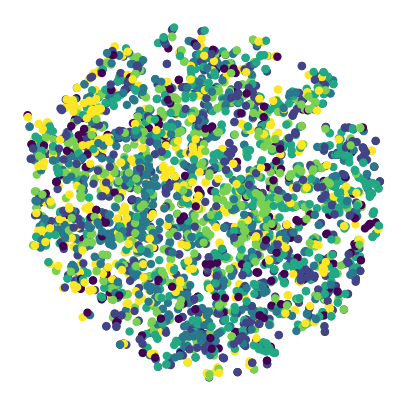

In [7]:
from sklearn.manifold import TSNE

untrained_gat = GAT(dataset.num_features, 8, dataset.num_classes)

# Get embeddings
h, _ = untrained_gat(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=25, c=data.y)
plt.show()

There's no apparent structure do the data. But do the embeddings produced by our trained model look better?

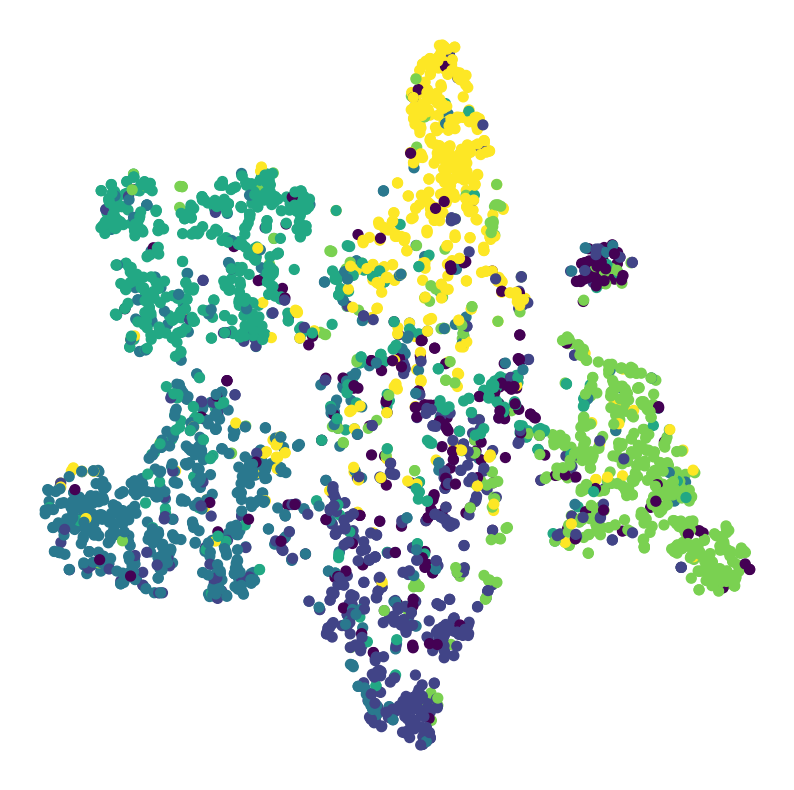

In [8]:
h, _ = gat(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

The difference is noticeable: **nodes belonging to the same classes cluster together**. We can see 6 clusters, corresponding to the 6 classes of papers. There are outliers, but this was to be expected: our accuracy is far from perfect.